In [1]:
import numpy as np

from scipy.optimize import curve_fit
import scipy.ndimage as ndimage
from scipy.io import loadmat
from ImageProcessing import *

import matplotlib.pyplot as plt
import matplotlib.scale as scale

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

from ImageProcessing import *
from ImageGenerator import ImageGenerator
from ImageClassifier import *

# Loading Data

In [2]:
data = loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

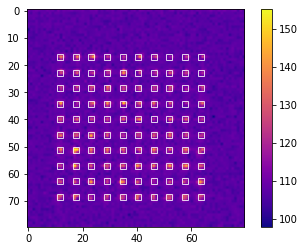

In [3]:

processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()

# Creating Labels with Thresholding Algorithm

In [14]:
crops, labels = processor.make_dataset(1, keep_unknowns=True)

[105.91666667 105.88888889 106.75       105.80555556 106.5
 105.47222222 106.5        106.5        109.22222222 104.83333333
 106.41666667 107.83333333 107.22222222 107.13888889 107.52777778
 107.25       106.80555556 106.63888889 105.08333333 106.11111111
 107.05555556 110.         107.5        105.5        108.08333333
 106.72222222 106.77777778 105.5        105.66666667 107.27777778
 104.72222222 106.41666667 104.72222222 106.08333333 106.52777778
 106.52777778 106.33333333 107.5        107.22222222 107.47222222
 108.02777778 107.30555556 108.41666667 107.44444444 106.16666667
 106.83333333 107.27777778 107.25       105.77777778 108.19444444
 105.38888889 105.30555556 105.91666667 106.27777778 105.91666667
 106.         108.41666667 106.80555556 106.52777778 106.16666667
 106.47222222 105.33333333 107.08333333 107.         106.5
 106.19444444 106.19444444 107.19444444 106.11111111 106.30555556
 105.91666667 105.69444444 105.80555556 107.61111111 106.22222222
 106.30555556 105.694444

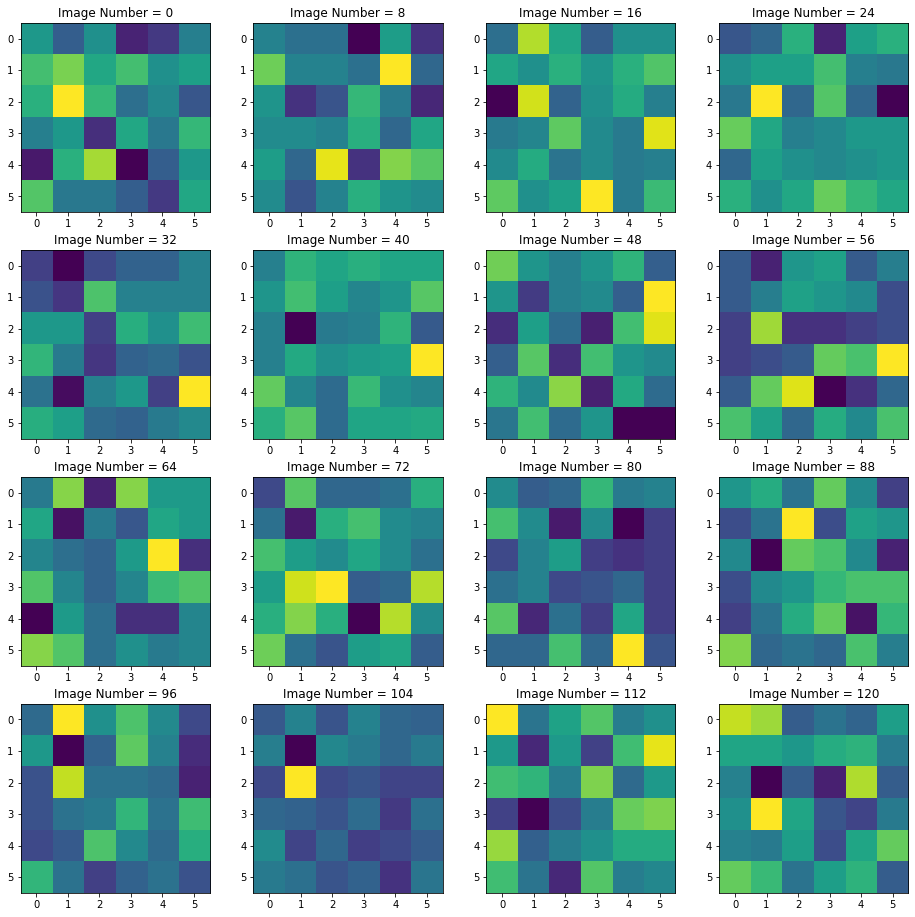

In [21]:
#i, j, k = np.random.randint(processor.n_tweezers), np.random.randint(processor.n_loops), np.random.randint(processor.per_loop - 4)
tweezer = 0

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for n in range(16):
    axs[n // 4, np.mod(n, 4)].imshow(crops[processor.crop_index(tweezer, 0, 8 * n)])
    axs[n // 4, np.mod(n, 4)].set_title(f"Image Number = {8 * n}")

2720


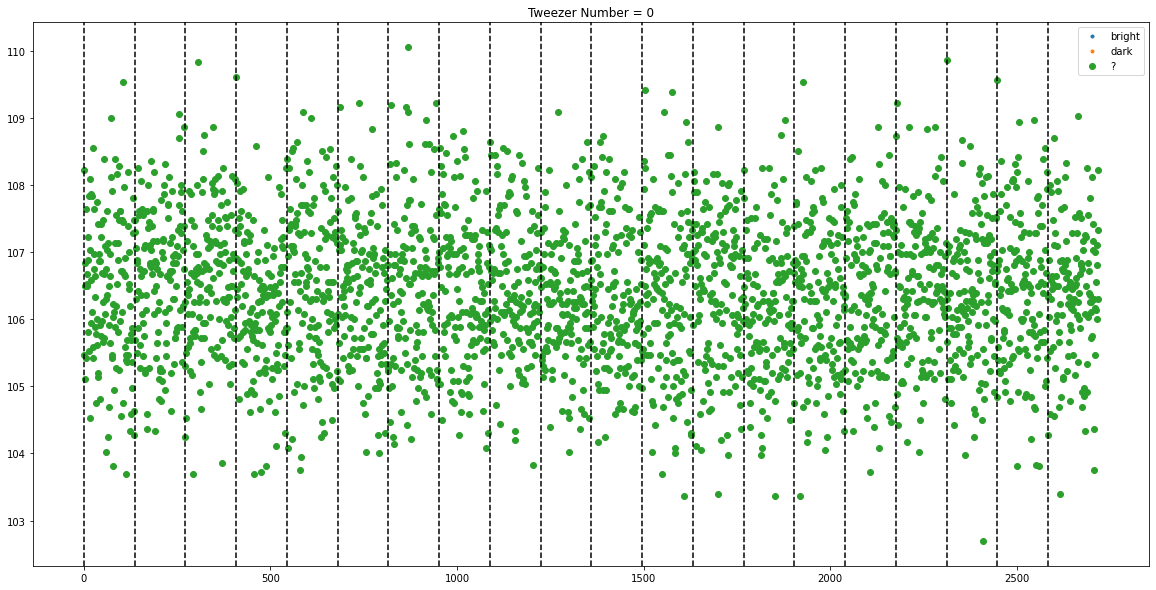

In [19]:
tweezer_vals = np.mean(crops[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)], axis=(1, 2))
tweezer_labels = labels[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)]

bright_mask = tweezer_labels == 1
dark_mask = tweezer_labels == 0
unknown_mask = np.isnan(tweezer_labels)

bright_indices = np.where(bright_mask)[0]
bright_vals = tweezer_vals[bright_mask]

dark_indices = np.where(dark_mask)[0]
dark_vals = tweezer_vals[dark_mask]

unknown_indices = np.where(unknown_mask)[0]
unknown_vals = tweezer_vals[unknown_mask]

print(len(unknown_vals))
plt.figure(figsize=(20, 10))
plt.plot(bright_indices, bright_vals, '.', label='bright')
plt.plot(dark_indices, dark_vals, '.', label='dark')
plt.plot(unknown_indices, unknown_vals, 'o', label='?')
#plt.axhline(upper_threshold, color='r', linestyle='--', label=f"Upper Threshold = {upper_threshold}")
#plt.axhline(lower_threshold, color='g', linestyle='--', label=f"Lower Threshold = {lower_threshold}")
plt.legend()
plt.title(f"Tweezer Number = {tweezer}")
for i in range(n_loops):
    plt.axvline(i * processor.per_loop, color='k', linestyle='--')
plt.show()

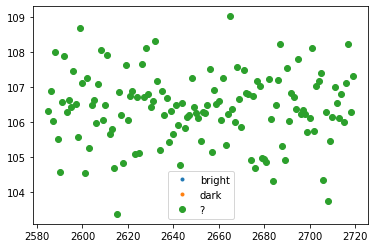

In [22]:
loop_num = 19
low = processor.per_loop * loop_num
high = processor.per_loop * (loop_num + 1)
bright_mask = (low < bright_indices) & (bright_indices < high)
dark_mask = (low < dark_indices) & (dark_indices < high)
unknown_mask = (low < unknown_indices) & (unknown_indices < high)

plt.plot(bright_indices[bright_mask], bright_vals[bright_mask], '.', label='bright')
plt.plot(dark_indices[dark_mask], dark_vals[dark_mask], '.', label='dark')
plt.plot(unknown_indices[unknown_mask], unknown_vals[unknown_mask], 'o', label='?')
#plt.axhline(upper_threshold, color='r', linestyle='--')
#plt.axhline(lower_threshold, color='r', linestyle='--')
plt.legend()
plt.show()

# Making a Neural Network For Training

In [23]:
images, labels = processor.make_dataset()


[105.91666667 105.88888889 106.75       105.80555556 106.5
 105.47222222 106.5        106.5        109.22222222 104.83333333
 106.41666667 107.83333333 107.22222222 107.13888889 107.52777778
 107.25       106.80555556 106.63888889 105.08333333 106.11111111
 107.05555556 110.         107.5        105.5        108.08333333
 106.72222222 106.77777778 105.5        105.66666667 107.27777778
 104.72222222 106.41666667 104.72222222 106.08333333 106.52777778
 106.52777778 106.33333333 107.5        107.22222222 107.47222222
 108.02777778 107.30555556 108.41666667 107.44444444 106.16666667
 106.83333333 107.27777778 107.25       105.77777778 108.19444444
 105.38888889 105.30555556 105.91666667 106.27777778 105.91666667
 106.         108.41666667 106.80555556 106.52777778 106.16666667
 106.47222222 105.33333333 107.08333333 107.         106.5
 106.19444444 106.19444444 107.19444444 106.11111111 106.30555556
 105.91666667 105.69444444 105.80555556 107.61111111 106.22222222
 106.30555556 105.694444

1.0


[]

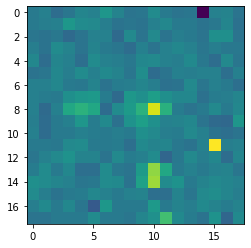

In [11]:
i = np.where(labels == 1)[0][0]
print(labels[i])
plt.imshow(images[i])
plt.plot()

In [12]:
model = models.Sequential()
model.add(layers.Input(shape=(images.shape[1], images.shape[2], 1)))
model.add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 10)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
#classifier = ImageClassifier(model)
#model.fit(images, labels, epochs=5)

# TODO
* Fine tune the thresholds for labeling 
* Automate testing and training for different hyperparameters
* Make multiple models to compare against each other
* Play around with individual site thresholds